# Optimización de Portafolios con Python


In [ ]:
import yfinance as yf  # datos financieros históricos
import numpy as np  # matrices y vectores
import matplotlib.pyplot as plt  # visualización
import scipy.optimize as opt  # optimización matemática

## Descarga de Datos Históricos
Usamos `yfinance` para obtener los precios de cierre de 5 acciones:
- **AAPL** (Apple)
- **MSFT** (Microsoft)
- **TSLA** (Tesla)
- **GOOGL** (Google)
- **AMZN** (Amazon)



In [ ]:
# Descarga de datos históricos de varias acciones
tickers = ["AAPL", "MSFT", "TSLA", "GOOGL", "AMZN"] #grupo tecnológico, crecimiento agresivo
#tickers = ["JNJ", "KO", "PG", "PFE", "WMT"] #grupo defensivo y conservador

data = yf.download(tickers, start="2023-01-01", end="2025-01-01")["Close"] # descargar precios de cierre

data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2023-01-03,123.470619,85.820000,88.695946,234.808945,108.099998
2023-01-04,124.744118,85.139999,87.660904,224.537659,113.639999
2023-01-05,123.421257,83.120003,85.789841,217.882843,110.339996
2023-01-06,127.962410,86.080002,86.924408,220.450684,113.059998
2023-01-09,128.485626,87.360001,87.601181,222.597092,119.769997


## Cálculo de Rendimientos Diarios
El **rendimiento diario** se calcula como:

$$ r_t = \frac{P_t - P_{t-1}}{P_{t-1}} $$


Donde:
- \( $P_t$ \) = Precio de cierre en el día $t$
- \( $P_{t-1} $\) = Precio del día anterior

Calcular rendimientos nos permite medir la variación diaria de los precios y analizar el riesgo.


In [ ]:
# Calcular rendimientos diarios
returns = data.pct_change().dropna()

rendimientos_esperados = returns.mean() # promedio de los rendimientos diarios de cada acción
returns.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2023-01-04,0.010314,-0.007924,-0.011670,-0.043743,0.051249
2023-01-05,-0.010605,-0.023726,-0.021344,-0.029638,-0.029039
2023-01-06,0.036794,0.035611,0.013225,0.011785,0.024651
2023-01-09,0.004089,0.014870,0.007786,0.009736,0.059349
2023-01-10,0.004457,0.028732,0.004544,0.007617,-0.007681


## Matriz de Covarianza
La **matriz de covarianza** mide la relación entre los rendimientos de diferentes activos.

$$
\text{Cov}(R_i, R_j) = \frac{1}{N-1} \sum_{t=1}^{N} (R_{i,t} - \mu_i)(R_{j,t} - \mu_j)
$$

Donde:
- $R_i,t$ es el rendimiento del activo $i$ en el instante de tiempo $t$
- $\mu_i$ es el promedio de los rendimientos del activo $i$
- $ N$ es el número de días
- $\mathrm{Cov}(R_{i}, R_{j})$ es la covarianza entre los activos $i$ y $j$.

Si la covarianza es **positiva**, las acciones tienden a moverse juntas, si es **negativa**, cuando una sube la otra baja.

Esto permite diversificar el riesgo: si combinamos activos que no se mueven igual, el portafolio puede ser más estable.


In [ ]:
# Calcular matriz de covarianza
cov_matrix = returns.cov()
cov_matrix

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Ticker,,,,,
AAPL,0.000181,0.000101,0.000109,0.000097,0.000186
AMZN,0.000101,0.000372,0.000204,0.000171,0.000241
GOOGL,0.000109,0.000204,0.000339,0.000141,0.000196
MSFT,0.000097,0.000171,0.000141,0.000204,0.000159
TSLA,0.000186,0.000241,0.000196,0.000159,0.001349


## Optimización de Portafolio - Mínima Varianza
Usamos `scipy.optimize` para encontrar la mejor combinación de activos con **el menor riesgo posible**.

**Restricciones**:
- Los pesos suman **100%**.  
- Ningún activo tiene más del **50%** del portafolio.  

El resultado muestra cuánto debemos invertir en cada acción.


In [ ]:
# --- PORTAFOLIO MÍNIMA VARIANZA ---

# función objetivo: calcular el riesgo (desviación estándar) del portafolio
def riesgo_portafolio(pesos, cov_matrix):
    return np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))  # cálculo de la volatilidad del portafolio (riesgo)

# restricciones
def restriccion_suma(pesos):
    return np.sum(pesos) - 1

limites = [(0, 0.5) for _ in tickers]

pesos_iniciales = np.array([1/len(tickers)] * len(tickers)) # distribución uniforme entre todas las acciones

# Optimización para encontrar el portafolio de mínima varianza
opt_res_min_var = opt.minimize(
    riesgo_portafolio,
    pesos_iniciales,
    args=(cov_matrix,),
    method="SLSQP",  # Sequential Least Squares Programming
    constraints={"type": "eq", "fun": restriccion_suma},  # restricción de suma de pesos
    bounds=limites  # restricciones de peso máximo y mínimo
)

pesos_min_var = opt_res_min_var.x # pesos del portafolio
rend_min_var = np.dot(pesos_min_var, rendimientos_esperados) # rendimiento esperado
riesgo_min_var = riesgo_portafolio(pesos_min_var, cov_matrix) # volatilidad

## Optimización de Portafolio - Máximo Sharpe
El **Ratio de Sharpe** mide la relación entre el riesgo y el retorno:

$$ S = \frac{R_p - R_f}{\sigma_p} $$

Donde $R_p$ representa el rendimiento esperado del portafolio, $R_f$ es la tasa libre de riesgo, y $σ_p$ es la volatilidad del portafolio (el riesgo total)


- **Cuanto más alto el Ratio de Sharpe**, mejor es el portafolio porque obtiene más rendimiento por cada unidad de riesgo.


In [ ]:
# --- PORTAFOLIO MÁXIMO SHARPE ---

# función objetivo: calcular el negativo del Ratio de Sharpe (porque scipy.minimize minimiza en lugar de maximizar)
def sharpe_ratio(pesos, rendimientos_esperados, cov_matrix, rf=0):
    rp = np.dot(pesos, rendimientos_esperados)  # rendimiento esperado del portafolio
    riesgo_portafolio = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))  # riesgo (volatilidad) del portafolio
    return -(rp - rf) / riesgo_portafolio  # ratio de Sharpe negativo

# Optimización para encontrar los pesos que maximizan el Ratio de Sharpe
opt_res_sharpe = opt.minimize(
    sharpe_ratio,
    pesos_iniciales,
    args=(rendimientos_esperados, cov_matrix),
    method="SLSQP",  # algoritmo de optimización cuadrática secuencial
    constraints={"type": "eq", "fun": restriccion_suma},  # restricción de suma de pesos
    bounds=limites   # restricciones de peso máximo y mínimo
)

pesos_max_sharpe = opt_res_sharpe.x # pesos del portafolio
rend_max_sharpe = np.dot(pesos_max_sharpe, rendimientos_esperados) # rendimiento esperado
riesgo_max_sharpe = riesgo_portafolio(pesos_max_sharpe, cov_matrix)# volatilidad


##  Optimización de Portafolio - Máximo Ratio Sortino
El **Ratio Sortino** es similar al Sharpe, pero solo considera el riesgo de pérdidas:

$$ S = \frac{R_p - R_f}{\sigma^-} $$


Donde $R_p$ representa el rendimiento esperado del portafolio, $R_f$ es la tasa libre de riesgo, y $σ_-$ es la desviación estandar de los rendimientos negativos (volatilidad de las pérdidas)

- Penaliza más los rendimientos negativos.  


In [ ]:
# ---  PORTAFOLIO MÁXIMO RATIO SORTINO  ---

# funcion objetivo: negativo del ratio sortino
def sortino_ratio(pesos, returns, rendimientos_esperados, rf=0):
    rp = np.dot(pesos, rendimientos_esperados)
    rend_diario_portafolio = np.dot(returns, pesos) # vector de rendimientos diarios
    rend_negativos = rend_diario_portafolio[rend_diario_portafolio < 0] #filtrar rendimientos negativos

    # desviacion a la baja
    riesgo_downside = np.std(rend_negativos, ddof=1)  # desviación estándar muestral
    return -(rp - rf) / riesgo_downside

opt_res_sortino = opt.minimize(
    sortino_ratio,
    pesos_iniciales,
    args=(returns, rendimientos_esperados),
    method="SLSQP",
    constraints={"type": "eq", "fun": restriccion_suma},
    bounds=limites
)

pesos_sortino = opt_res_sortino.x
rend_sortino = np.dot(pesos_sortino, rendimientos_esperados)
riesgo_sortino = riesgo_portafolio(pesos_sortino, cov_matrix)

## Portafolio Equilibrado
(50% Mínima Varianza + 50% Máximo Sharpe)

Este portafolio busca un **balance** entre **bajo riesgo** y **buen rendimiento**.


- Reduce el riesgo sin sacrificar demasiado rendimiento.  
- Es más estable que un portafolio 100% optimizado para rendimiento.  


In [ ]:
# ---  PORTAFOLIO EQUILIBRADO  ---

pesos_equilibrado = (pesos_min_var + pesos_max_sharpe) / 2 # promediar los pesos del portafolio de mínima varianza y del de máximo Sharpe
rend_equilibrado = np.dot(pesos_equilibrado, rendimientos_esperados) # rendimiento esperado
riesgo_equilibrado = riesgo_portafolio(pesos_equilibrado, cov_matrix) # volatilidad

##  Simulación de Portafolios Aleatorios
Para visualizar la **Frontera Eficiente**, simulamos **10,000 portafolios aleatorios** con combinaciones de pesos diferentes.

Con esto, buscamos ver qué combinaciones tienen menor riesgo, comparar con los portafolios optimizados y construir la Frontera Eficiente.  



In [ ]:
# ---  SIMULACIÓN DE PORTAFOLIOS ALEATORIOS ---

num_portafolios = 10000
resultados = np.zeros((3, num_portafolios)) # matriz para guardar rendimiento, riesgo y ratio Sharpe de cada portafolio

np.random.seed(23) # fijar la semilla
for i in range(num_portafolios):
    pesos = np.random.random(len(tickers)) # generar pesos aleatorios para cada activo
    pesos /= np.sum(pesos)  # normalizar para que sumen 1 (100% del capital invertido)

    rendimiento_portafolio = np.dot(pesos, rendimientos_esperados)
    riesgo_portafolio_val = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))

    resultados[0, i] = rendimiento_portafolio # rendimiento esperado
    resultados[1, i] = riesgo_portafolio_val # volatilidad
    resultados[2, i] = rendimiento_portafolio / riesgo_portafolio_val  # ratio de Sharpe

##  Gráfica de la Frontera Eficiente
La **Frontera Eficiente** es la curva de portafolios óptimos según la **Teoría Moderna de Portafolios** de Markowitz.

- Cada punto en la gráfica representa un **portafolio diferente** con combinaciones distintas de activos, la coloración indica el ratio del sharpe (de azul a rojo)
- Los portafolios en la **curva de la frontera eficiente** son los mejores posibles.  
- **Portafolios por debajo de la frontera** son ineficientes, porque existe una mejor combinación de activos con menos riesgo o más rendimiento.  

**Interpretación de la gráfica:**

- **Circulos:** Portafolios aleatorios.  
- **Estrella azul:** Portafolio de **Mínima Varianza** (menor riesgo).  
- **Estrella roja:** Portafolio de **Máximo Sharpe** (mejor rendimiento-riesgo).  
- **Estrella verde:** Portafolio de **Máximo Sortino** (mejor relación riesgo negativo).
- **Estrella amarilla:** Portafolio **Equilibrado**


En la gráfica el eje x modela el riesgo (Desviación Estándar), mientras que el eje y modela el rendimiento esperado

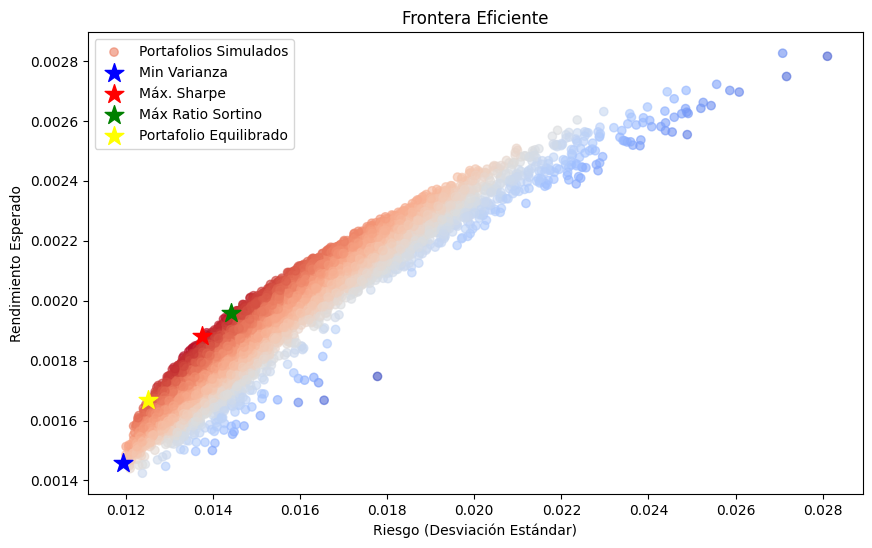

In [ ]:
# --- GRAFICAR LA FRONTERA EFICIENTE ---

plt.figure(figsize=(10, 6))

# graficar todos los portafolios simulados como puntos de colores según su ratio Sharpe
plt.scatter(
    resultados[1], resultados[0],  # eje x: riesgo, eje y: rendimiento
    c=resultados[2],  # color según el ratio Sharpe
    cmap="coolwarm",  # mapa de colores
    alpha=0.6,  # transparencia
    label="Portafolios Simulados"
)

plt.scatter(riesgo_min_var, rend_min_var, color="blue", marker="*", s=200, label="Min Varianza")
plt.scatter(riesgo_max_sharpe, rend_max_sharpe, color="red", marker="*", s=200, label="Máx. Sharpe")
plt.scatter(riesgo_sortino, rend_sortino, color="green", marker="*", s=200, label="Máx Ratio Sortino")
plt.scatter(riesgo_equilibrado, rend_equilibrado, color="yellow", marker="*", s=200, label="Portafolio Equilibrado")

plt.xlabel("Riesgo (Desviación Estándar)")
plt.ylabel("Rendimiento Esperado")
plt.title("Frontera Eficiente")
plt.legend()  # etiquetas de los portafolios
plt.show()


In [ ]:

# ---  IMPRIMIR RESULTADOS DE TODOS LOS PORTAFOLIOS  ---

print("\n🔵 Pesos del portafolio de mínima varianza:")
for asset, weight in zip(tickers, pesos_min_var):
    print(f"{asset}: {weight:.2%}")

print(f"\n Rendimiento esperado (diario): {rend_min_var:.2%}")
print(f" Riesgo esperado (diario): {riesgo_min_var:.2%}")

print("\n🔴 Pesos del portafolio de máximo Sharpe:")
for asset, weight in zip(tickers, pesos_max_sharpe):
    print(f"{asset}: {weight:.2%}")

print(f"\n Rendimiento esperado (diario): {rend_max_sharpe:.2%}")
print(f" Riesgo esperado (diario): {riesgo_max_sharpe:.2%}")

print(f"\n🟢 Pesos del portafolio de máximo Ratio Sortino:")
for asset, weight in zip(tickers, pesos_sortino):
    print(f"{asset}: {weight:.2%}")

print(f"\n Rendimiento esperado (diario): {rend_sortino:.2%}")
print(f" Riesgo esperado (diario): {riesgo_sortino:.2%}")

print("\n🟡 Pesos del Portafolio Equilibrado (50% Mín. Var. + 50% Máx. Sharpe):")
for asset, weight in zip(tickers, pesos_equilibrado):
    print(f"{asset}: {weight:.2%}")

print(f"\n Rendimiento esperado (diario): {rend_equilibrado:.2%}")
print(f" Riesgo esperado (diario): {riesgo_equilibrado:.2%}")


🔵 Pesos del portafolio de mínima varianza:
AAPL: 50.00%
MSFT: 3.75%
TSLA: 11.16%
GOOGL: 35.09%
AMZN: 0.00%

 Rendimiento esperado (diario): 0.15%
 Riesgo esperado (diario): 1.19%

🔴 Pesos del portafolio de máximo Sharpe:
AAPL: 49.45%
MSFT: 29.96%
TSLA: 9.55%
GOOGL: 0.00%
AMZN: 11.03%

 Rendimiento esperado (diario): 0.19%
 Riesgo esperado (diario): 1.38%

🟢 Pesos del portafolio de máximo Ratio Sortino:
AAPL: 50.00%
MSFT: 35.42%
TSLA: 0.00%
GOOGL: 0.06%
AMZN: 14.53%

 Rendimiento esperado (diario): 0.20%
 Riesgo esperado (diario): 1.44%

🟡 Pesos del Portafolio Equilibrado (50% Mín. Var. + 50% Máx. Sharpe):
AAPL: 49.73%
MSFT: 16.86%
TSLA: 10.36%
GOOGL: 17.54%
AMZN: 5.52%

 Rendimiento esperado (diario): 0.17%
 Riesgo esperado (diario): 1.25%


## Volatilidad Anualizada
La **volatilidad anualizada** mide el **riesgo total** de cada portafolio en un año.  

**¿Por qué usamos `sqrt(252)`?**
- Hay aproximadamente **252 días de trading** en un año.
- La volatilidad crece con la **raíz cuadrada del tiempo**.

Un portafolio con menor volatilidad es **más estable**, mientras que un portafolio con mayor volatilidad es **más riesgoso**, pero puede tener más rendimiento.  


In [ ]:
# ---  CALCULAR VOLATILIDAD ANUALIZADA  ---

volatilidad_min_var = riesgo_min_var * np.sqrt(252)
volatilidad_max_sharpe = riesgo_max_sharpe * np.sqrt(252)
volatilidad_sortino = riesgo_sortino * np.sqrt(252)
volatilidad_equilibrado = riesgo_equilibrado * np.sqrt(252)

print("\n Volatilidad anualizada de cada portafolio:")
print(f"🔵 Mínima Varianza: {volatilidad_min_var:.2%}")
print(f"🔴 Máximo Sharpe: {volatilidad_max_sharpe:.2%}")
print(f"🟢 Máximo Ratio Sortino: {volatilidad_sortino:.2%}")
print(f"🟡 Equilibrado: {volatilidad_equilibrado :.2%}")


 Volatilidad anualizada de cada portafolio:
🔵 Mínima Varianza: 18.94%
🔴 Máximo Sharpe: 21.84%
🟢 Máximo Ratio Sortino: 22.89%
🟡 Equilibrado: 19.87%


## Rendimiento Esperado Anualizado
Convertimos el rendimiento diario a un rendimiento **anualizado** con la fórmula:

$$R_{\text{anual}} = (1 + R_{\text{diario}})^{252} - 1$$

- Cada día el rendimiento se **compone** sobre el anterior.
- Hay **252 días hábiles** en un año, por lo que elevamos a la **potencia 252**.

Un portafolio con **mayor rendimiento anualizado** es más atractivo, pero hay que balancearlo con la **volatilidad** para no asumir demasiado riesgo.  


In [ ]:
# ---  CONVERTIR RENDIMIENTO ESPERADO DIARIO A ANUAL  ---

rend_anual_min_var = (1 + rend_min_var) ** 252 - 1
rend_anual_max_sharpe = (1 + rend_max_sharpe) ** 252 - 1
rend_anual_sortino = (1 + rend_sortino) ** 252 - 1
rend_anual_equilibrado = (1 + rend_equilibrado) ** 252 - 1

print("\n Rendimiento esperado anualizado de cada portafolio:")
print(f"🔵 Mínima Varianza: {rend_anual_min_var:.2%}")
print(f"🔴 Máximo Sharpe: {rend_anual_max_sharpe:.2%}")
print(f"🟢 Máximo Ratio Sortino: {rend_anual_sortino:.2%}")
print(f"🟡 Equilibrado: {rend_anual_equilibrado:.2%}")


 Rendimiento esperado anualizado de cada portafolio:
🔵 Mínima Varianza: 44.32%
🔴 Máximo Sharpe: 60.63%
🟢 Máximo Ratio Sortino: 63.72%
🟡 Equilibrado: 52.25%
